In [1]:
#!git clone https://github.com/darrenyaoyao/HLSFinal.git
!pip3 install -r /content/HLSFinal/requirement.txt
!pip3 install joblib

In [2]:
import os
os.chdir("/content/HLSFinal")

In [3]:
import os
import glob

from PIL import Image, ImageDraw


def get_files(path='./', ext=('.png', '.jpeg', '.jpg')):
    """ Get all image files """
    files = []
    for e in ext:
        files.extend(glob.glob(f'{path}/**/*{e}'))
    files.sort(key=lambda p: (os.path.dirname(p), int(os.path.basename(p).split('.')[0])))
    return files

def to_rgb_and_save(path):
    """ Some of the images may have RGBA mode """
    for p in path:
        img = Image.open(p)
        if img.mode != 'RGB':
            img = img.convert('RGB')
            img.save(p)

ABS_PATH = './'
DATA_PATH = os.path.join(ABS_PATH, 'data')

TRAIN_DIR = os.path.join(DATA_PATH, 'train_images')
TEST_DIR = os.path.join(DATA_PATH, 'test_images')

ALIGNED_TRAIN_DIR = TRAIN_DIR + '_cropped'
ALIGNED_TEST_DIR = TEST_DIR + '_cropped'

In [4]:
from collections import Counter


# 1. Get path for TRAIN_DIR/TEST_DIR
trainF, testF = get_files(TRAIN_DIR), get_files(TEST_DIR)

# prepare info for printing
trainC, testC = Counter(map(os.path.dirname, trainF)), Counter(map(os.path.dirname, testF))
train_total, train_text  = sum(trainC.values()), '\n'.join([f'\t- {os.path.basename(fp)} - {c}' for fp, c in trainC.items()])
test_total, test_text  = sum(testC.values()), '\n'.join([f'\t- {os.path.basename(fp)} - {c}' for fp, c in testC.items()])

print(f'Train files\n\tpath: {TRAIN_DIR}\n\ttotal number: {train_total}\n{train_text}')
print(f'Train files\n\tpath: {TEST_DIR}\n\ttotal number: {test_total}\n{test_text}')

to_rgb_and_save(trainF), to_rgb_and_save(testF)

Train files
	path: ./data/train_images
	total number: 18
	- adele - 2
	- ariana grande - 2
	- biden - 2
	- curry - 2
	- jay chou - 2
	- jennifer aniston - 2
	- jessica - 2
	- justin bieber - 2
	- trump - 2
Train files
	path: ./data/test_images
	total number: 9
	- adele - 1
	- ariana grande - 1
	- biden - 1
	- curry - 1
	- jay chou - 1
	- jennifer aniston - 1
	- jessica - 1
	- justin bieber - 1
	- trump - 1


(None, None)

In [5]:

from facenet_pytorch import MTCNN, InceptionResnetV1, training, fixed_image_standardization
import tqdm
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import shutil
from brevitas.quant_tensor import QuantTensor

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Running on device: {device}')


def crop_face_and_save(path, new_path=None, model=MTCNN, transformer=None, params=None):
    """
    Detect face on each image, crop them and save to "new_path"
    :param str path: path with images will be passed to  datasets.ImageFolder
    :param str new_path: path to locate new "aligned" images, if new_path is None
                     then new_path will be path + "_cropped"
    :param model: model to detect faces, default MTCNN
    :param transformer: transformer object will be passed to ImageFolder
    :param params: parameters of MTCNN model
    """
    if not new_path:
        new_path = path + '_cropped'

    # in case new_path exists MTCNN model will raise error
    if os.path.exists(new_path):
        shutil.rmtree(new_path)

    # it is default parameters for MTCNN
    if not params:
        params = {
            'image_size': 160, 'margin': 0,
            'min_face_size': 10, 'thresholds': [0.6, 0.7, 0.7],
            'factor': 0.709, 'post_process': False, 'device': device
            }

    model = model(**params)

    if not transformer:
        transformer = transforms.Lambda(
            lambd=lambda x: x.resize((1280, 1280)) if (np.array(x) > 2000).all() else x
        )
    # for convenience we will use ImageFolder instead of getting Image objects by file paths
    dataset = datasets.ImageFolder(path, transform=transformer)
    dataset.samples = [(p, p.replace(path, new_path)) for p, _ in dataset.samples]

    # batch size 1 as long as we havent exact image size and MTCNN will raise an error
    loader = DataLoader(dataset, batch_size=1, collate_fn=training.collate_pil)
    for i, (x, y) in enumerate(tqdm.tqdm(loader)):
        model(x, save_path=y)

    # spare some memory
    del model, loader, dataset

# 3. Crop train dataset faces and save aligned images
print('\t- Train data')
crop_face_and_save(TRAIN_DIR, ALIGNED_TRAIN_DIR)

# check if some imgs were missed by detector and failed to save
train_files, train_aligned_files = get_files(TRAIN_DIR), get_files(ALIGNED_TRAIN_DIR)
if len(train_files) != len(train_aligned_files):
    files = set(map(lambda fp: os.path.relpath(fp, start=TRAIN_DIR), train_files))
    aligned_files = set(map(lambda fp: os.path.relpath(fp, start=ALIGNED_TRAIN_DIR), train_aligned_files))
    detect_failed_train_files = list(files - aligned_files)
    print(f"\nfiles {len(aligned_files)}/{len(files)}: {', '.join(detect_failed_train_files)} were not saved")

# -------------                     -------------

# Crop test dataset faces and save aligned images
print('\t- Test data')
crop_face_and_save(TEST_DIR, ALIGNED_TEST_DIR)

# check if some imgs were missed by detector and failed to save
test_files, test_aligned_files = get_files(TEST_DIR), get_files(ALIGNED_TEST_DIR)
if len(test_files) != len(test_aligned_files):
    files = set(map(lambda fp: os.path.relpath(fp, start=TEST_DIR), test_files))
    aligned_files = set(map(lambda fp: os.path.relpath(fp, start=ALIGNED_TEST_DIR), test_aligned_files))
    detect_failed_test_files = list(files - aligned_files)
    print(f"\nfiles {len(aligned_files)}/{len(files)}: {', '.join(detect_failed_train_files)} were not saved")

trainF = get_files(ALIGNED_TRAIN_DIR)
testF = get_files(ALIGNED_TEST_DIR)

import albumentations as A

from facenet_pytorch import fixed_image_standardization

standard_transform = transforms.Compose([
                                np.float32,
                                transforms.ToTensor(),
                                fixed_image_standardization
])

aug_mask = A.Compose([
                   A.HorizontalFlip(p=0.5),
                   A.VerticalFlip(p=0.15),
                   A.RandomContrast(limit=0.5, p=0.4),
                   A.Rotate(30, p=0.2),
                   A.RandomSizedCrop((120, 120), 160, 160, p=0.4),
                   A.OneOrOther(A.JpegCompression(p=0.2), A.Blur(p=0.2), p=0.66),
                   A.OneOf([
                            A.Rotate(45, p=0.3),
                            A.ElasticTransform(sigma=20, alpha_affine=20, border_mode=0, p=0.2)
                            ], p=0.5),
                  A.HueSaturationValue(val_shift_limit=10, p=0.3)
            ], p=1)

transform = {
    'train': transforms.Compose([
                      transforms.Lambda(lambd=lambda x: aug_mask(image=np.array(x))['image']),
                      standard_transform
                  ]),
    'test': standard_transform
}

from torch.utils.data import SubsetRandomSampler


b = 32

# Original train images
trainD = datasets.ImageFolder(ALIGNED_TRAIN_DIR, transform=standard_transform)
# Augmented train images
trainD_aug = datasets.ImageFolder(ALIGNED_TRAIN_DIR, transform=transform['train'])
# Train Loader
trainL = DataLoader(trainD, batch_size=b, num_workers=2) # x: torch.Size([batch_size, 3, 160, 160]), y: torch.Size([batch_size])
trainL_aug = DataLoader(trainD_aug, batch_size=b, num_workers=2)

# Original test images
testD = datasets.ImageFolder(ALIGNED_TEST_DIR, transform=standard_transform)
# Test Loader
testL = DataLoader(testD, batch_size=b, num_workers=2)

# Convert encoded labels to named claasses
IDX_TO_CLASS = np.array(list(trainD.class_to_idx.keys()))
CLASS_TO_IDX = dict(trainD.class_to_idx.items())

from model import QuantWeightLeNet
#del model
model = QuantWeightLeNet().to(device)

def fixed_denormalize(image):
    """ Restandartize images to [0, 255]"""
    return image * 128 + 127.5

from random import randrange

criterion = torch.nn.TripletMarginLoss(margin=0.05, p=2).to(device=device)
optimizer = torch.optim.Adam(model.parameters(),
                                lr=1e-5,
                                weight_decay=0.9)

# Training
model
for n_i in tqdm.trange(1):
    for i, (x, y) in enumerate(trainL, 1):

        x = fixed_denormalize(x)
        anchor_x = x[[0,2,4,6,8,10,12,14,16]]
        anchor_y = y[[0,2,4,6,8,10,12,14,16]]
        positive_x = x[[1,3,5,7,9,11,13,15,17]]
        positive_y = y[[1,3,5,7,9,11,13,15,17]]

        negative_index = [randrange(2,18),
                          randrange(0,2) if randrange(0,2) else randrange(4, 18),
                          randrange(0,4) if randrange(0,2) else randrange(6, 18),
                          randrange(0,6) if randrange(0,2) else randrange(8, 18),
                          randrange(0,8) if randrange(0,2) else randrange(10, 18),
                          randrange(0,10) if randrange(0,2) else randrange(12, 18),
                          randrange(0,12) if randrange(0,2) else randrange(14, 18),
                          randrange(0,14) if randrange(0,2) else randrange(16, 18),
                          randrange(0,16)]

        negative_x = x[negative_index]
        negative_y = y[negative_index]

        anchor_embed = model(anchor_x.to(device))
        positive_embed = model(positive_x.to(device))
        negative_embed = model(negative_x.to(device))

        loss = criterion(anchor_embed, positive_embed, negative_embed)
        print(n_i, ": ", loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()



Running on device: cuda:0
	- Train data


100%|██████████| 18/18 [00:12<00:00,  1.49it/s]


	- Test data


  0%|          | 0/1 [00:00<?, ?it/s]

0 :  0.05977104231715202


100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


In [6]:
model.fc3

QuantLinear(
  in_features=84, out_features=9, bias=False
  (input_quant): ActQuantProxyFromInjector(
    (_zero_hw_sentinel): StatelessBuffer()
  )
  (output_quant): ActQuantProxyFromInjector(
    (_zero_hw_sentinel): StatelessBuffer()
  )
  (weight_quant): WeightQuantProxyFromInjector(
    (_zero_hw_sentinel): StatelessBuffer()
    (tensor_quant): RescalingIntQuant(
      (int_quant): IntQuant(
        (float_to_int_impl): RoundSte()
        (tensor_clamp_impl): TensorClampSte()
        (delay_wrapper): DelayWrapper(
          (delay_impl): _NoDelay()
        )
      )
      (scaling_impl): StatsFromParameterScaling(
        (parameter_list_stats): _ParameterListStats(
          (first_tracked_param): _ViewParameterWrapper(
            (view_shape_impl): OverTensorView()
          )
          (stats): _Stats(
            (stats_impl): AbsMax()
          )
        )
        (stats_scaling_impl): _StatsScaling(
          (affine_rescaling): Identity()
          (restrict_clamp_scaling)

In [7]:
from math import ceil 

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline 

from matplotlib.patches import Ellipse


def imshow(img, ax, title):  
    ax.imshow(img)
    if title:
        el = Ellipse((2, -1), 0.5, 0.5)
        ax.annotate(title, xy=(1, 0), xycoords='axes fraction', ha='right', va='bottom',
                    bbox=dict(boxstyle="round", fc="0.8"), 
                    arrowprops=dict(arrowstyle="simple", fc="0.6", ec="none", 
                                    patchB=el, connectionstyle="arc3, rad=0.3"))
    ax.set_xticks([]), ax.set_yticks([])

def plot_gallery(images, ncols, nrows, titles=None, title='', figsize=None): 
    if figsize is None: 
        figsize = (18, ncols) if ncols < 10 else (18, 20)  
    fig = plt.figure(figsize=figsize)
    grid = ImageGrid(fig, 111, nrows_ncols=(nrows, ncols), axes_pad=0.02)

    for i, ax in enumerate(grid): 
        if i == len(images): break 
        imshow(images[i], ax, titles[i] if titles is not None else '')

    # there are some problems with suptitle alignment 
    y_title_pos = grid[0].get_position().get_points()[1][1] - 0.33 / (1 if nrows == 1 else nrows / 3)
    plt.suptitle(title, y=y_title_pos, fontsize=12)

def plot(paths=None, images=None, titles=None, axtitle=True, title='', to_size=(512, 512)): 
    """
    Plot image gallery by passing (paths, title) or (images, titles)
    :param paths: list of image paths
    :param images: list of (PIL.Image | np.array | torch.Tensor) objects 
    :param titles: list of image titles 
    :param bool axtitle: if paths is not None, then axtitle=True leads to use basedir name as titles 
    :param str title: gallery title   
    :param to_size: image resizing size before plot, default (512, 512)
    """

    if paths is not None and len(paths): 
        images = [Image.open(p).resize(to_size) for p in paths]

        nrows = int(ceil(len(images) / 12)) # 12 images per row 
        ncols = 12 if nrows > 1 else len(images)

        if axtitle: 
              titles = [os.path.dirname(p).split('/')[-1] for p in paths]

        plot_gallery(images, ncols, nrows, titles, title)

    elif images is not None and len(images): 
        if isinstance(images, list): 
            images = np.array(images)

        nrows = int(ceil(len(images) / 12)) # 12 images per row 
        ncols = 12 if nrows > 1 else len(images)

        # Rescale to [0., 1.]
        if images[0].max() > 1: 
            images /= 255. 

        # if torch.Tensor change axes 
        if not isinstance(images, np.ndarray): 
            if images.size(1) == 3 or 1: 
                images = images.permute((0, 2, 3, 1))

        plot_gallery(images, ncols, nrows, titles, title)


    else: 
        raise LookupError('You didnt pass any path or image objects')
    plt.show()

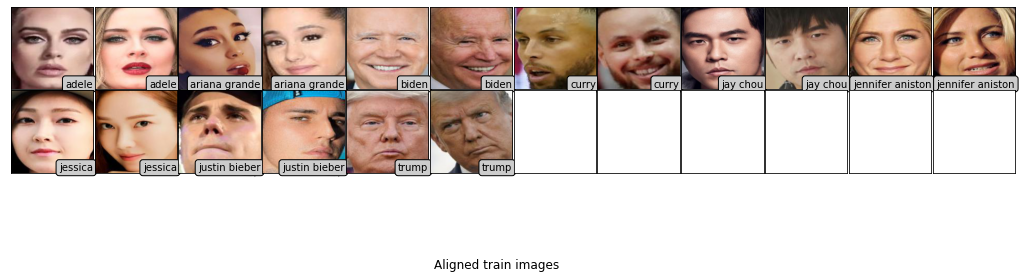

In [8]:
trainF = get_files(ALIGNED_TRAIN_DIR)
plot(paths=trainF, title='Aligned train images')

In [12]:
def fixed_denormalize(image): 
    """ Restandartize images to [0, 255]"""
    return image * 128 + 127.5

def getEmbeds(model, n, loader, imshow=False, n_img=5):
    model.eval()
    # images to display 
    images = []

    embeds, labels = [], []
    for n_i in tqdm.trange(n): 
        for i, (x, y) in enumerate(loader, 1): 

            # on each first batch get 'n_img' images  
            if imshow and i == 1: 
                inds = np.random.choice(x.size(0), min(x.size(0), n_img))
                images.append(fixed_denormalize(x[inds].data.cpu()).permute((0, 2, 3, 1)).numpy())

            embed = model(x.to(device))
            embed = embed.cpu().detach().numpy()
            embeds.append(embed), labels.extend(y.data.cpu().numpy())

    if imshow: 
        plot(images=np.concatenate(images))

    return np.concatenate(embeds), np.array(labels)

In [13]:
# model.eval()
# # images to display 
# images = []
# loader = trainL
# n_img=1
# embeds, labels = [], []
# for n_i in tqdm.trange(1): 
#     for i, (x, y) in enumerate(loader, 1): 

#         # on each first batch get 'n_img' images  
#         if imshow and i == 1: 
#             inds = np.random.choice(x.size(0), min(x.size(0), n_img))
#             images.append(fixed_denormalize(x[inds].data.cpu()).permute((0, 2, 3, 1)).numpy())

#         embed = model(x.to(device))
#         print(embed.shape)

100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

torch.Size([18, 9])


100%|██████████| 50/50 [00:17<00:00,  2.87it/s]


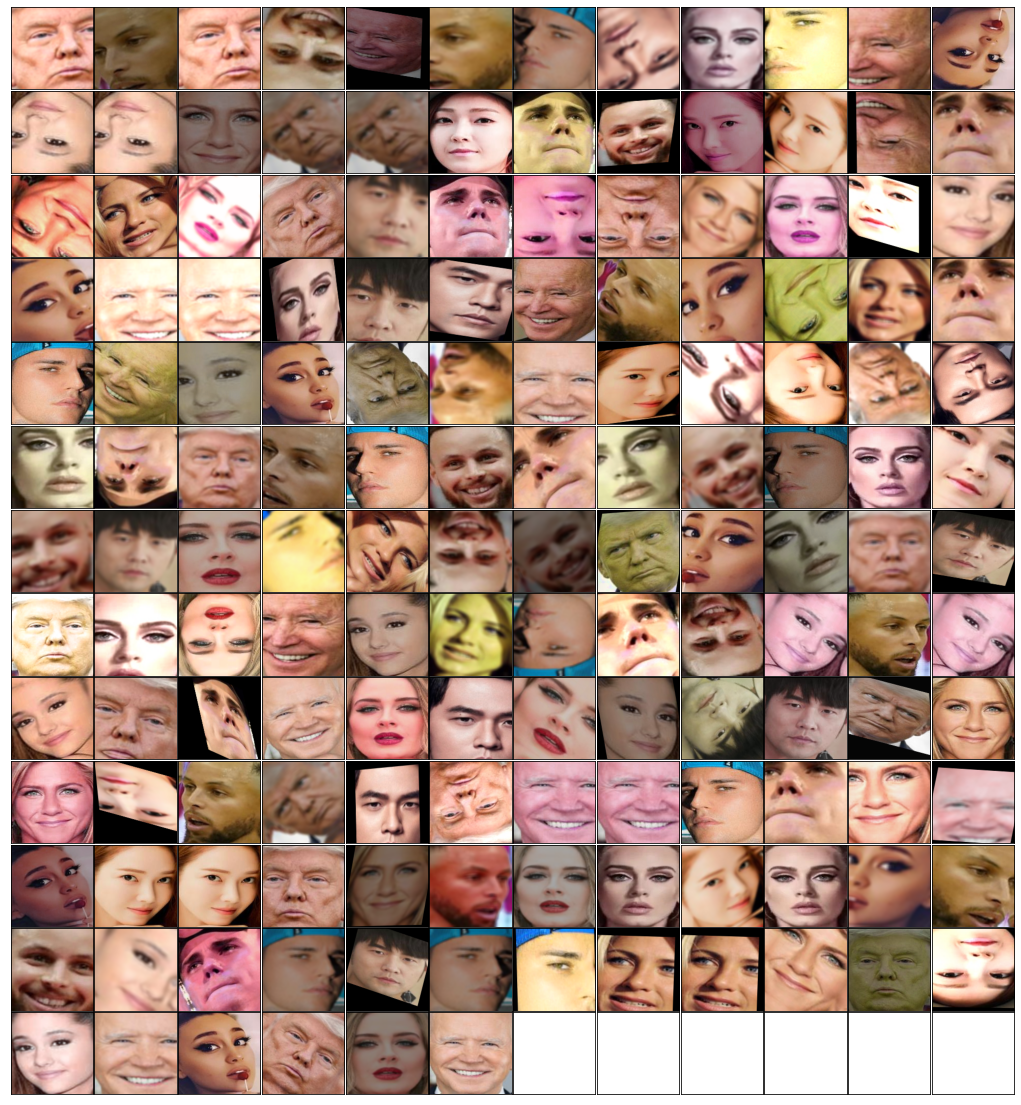

100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


In [14]:
# 3. Get embeddings 
# Train embeddings 
trainEmbeds, trainLabels = getEmbeds(model.to(device), 1, trainL, False)
trainEmbeds_aug, trainLabels_aug = getEmbeds(model.to(device), 50, trainL_aug, imshow=True, n_img=3)

trainEmbeds = np.concatenate([trainEmbeds, trainEmbeds_aug])
trainLabels = np.concatenate([trainLabels, trainLabels_aug])

# Test embeddings 
testEmbeds, testLabels = getEmbeds(model, 1, testL, False)

In [15]:
from brevitas.export import FINNManager

FINNManager.export(model.to('cpu'), input_shape=(1, 3, 160, 160), export_path="facenet.onnx")

ir_version: 7
producer_name: "pytorch"
producer_version: "1.10"
graph {
  node {
    input: "inp.1"
    input: "23"
    output: "24"
    name: "Conv_1"
    op_type: "Conv"
    attribute {
      name: "dilations"
      ints: 1
      ints: 1
      type: INTS
    }
    attribute {
      name: "group"
      i: 1
      type: INT
    }
    attribute {
      name: "kernel_shape"
      ints: 3
      ints: 3
      type: INTS
    }
    attribute {
      name: "pads"
      ints: 0
      ints: 0
      ints: 0
      ints: 0
      type: INTS
    }
    attribute {
      name: "strides"
      ints: 1
      ints: 1
      type: INTS
    }
    domain: ""
  }
  node {
    input: "24"
    input: "25"
    output: "26"
    name: "Mul_3"
    op_type: "Mul"
  }
  node {
    input: "26"
    input: "27"
    output: "28"
    name: "MultiThreshold_5"
    op_type: "MultiThreshold"
    attribute {
      name: "out_dtype"
      s: "UINT4"
      type: STRING
    }
    domain: "finn.custom_op.general"
  }
  node {
    

In [16]:
# 4. Save embeddings 
TRAIN_EMBEDS = os.path.join(DATA_PATH, 'trainEmbeds.npz')
TEST_EMBEDS = os.path.join(DATA_PATH, 'testEmbeds.npz')

np.savez(TRAIN_EMBEDS, x=trainEmbeds, y=trainLabels)
np.savez(TEST_EMBEDS, x=testEmbeds, y=testLabels)

# Load the saved embeddings to use them futher 
trainEmbeds, trainLabels = np.load(TRAIN_EMBEDS, allow_pickle=True).values()
testEmbeds, testLabels = np.load(TEST_EMBEDS, allow_pickle=True).values()

# Get named labels
trainLabels, testLabels = IDX_TO_CLASS[trainLabels], IDX_TO_CLASS[testLabels]

In [17]:
from sklearn.metrics import pairwise_distances
import pandas as pd
import seaborn as sns 
sns.set()

def getDist(x, metric='euclidean', index=None, columns=None):
    dists = pairwise_distances(x, x, metric=metric)
    return pd.DataFrame(dists, index=index, columns=columns)

def heatmap(x, title='', cmap='Greens', linewidth=1):
    plt.figure(figsize=(17, 12))
    plt.title(title)
    sns.heatmap(x, cmap=cmap, square=True)
    plt.show()

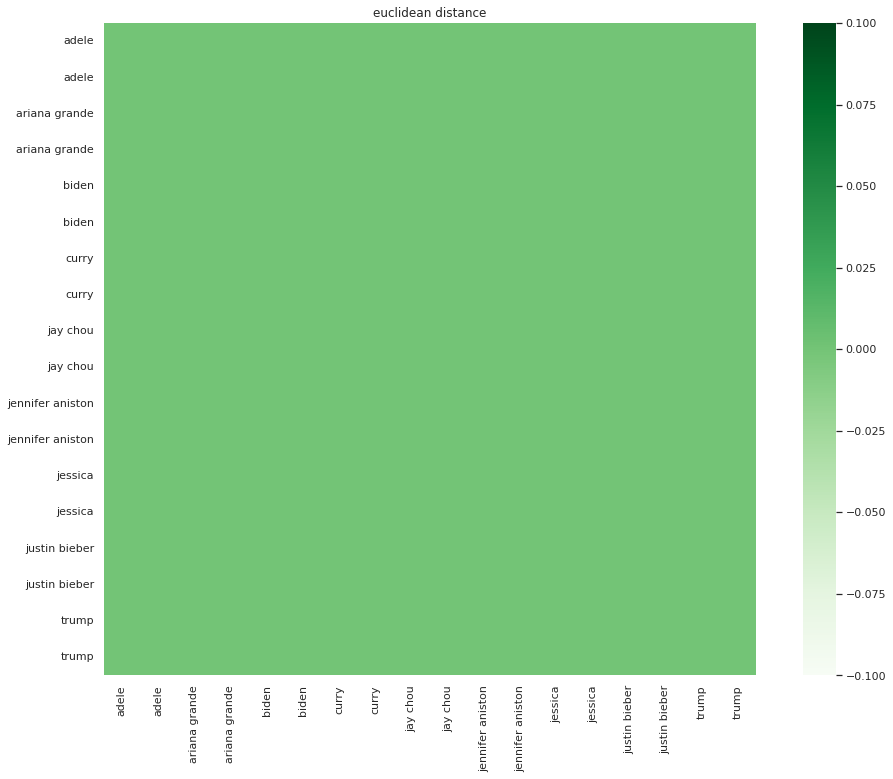

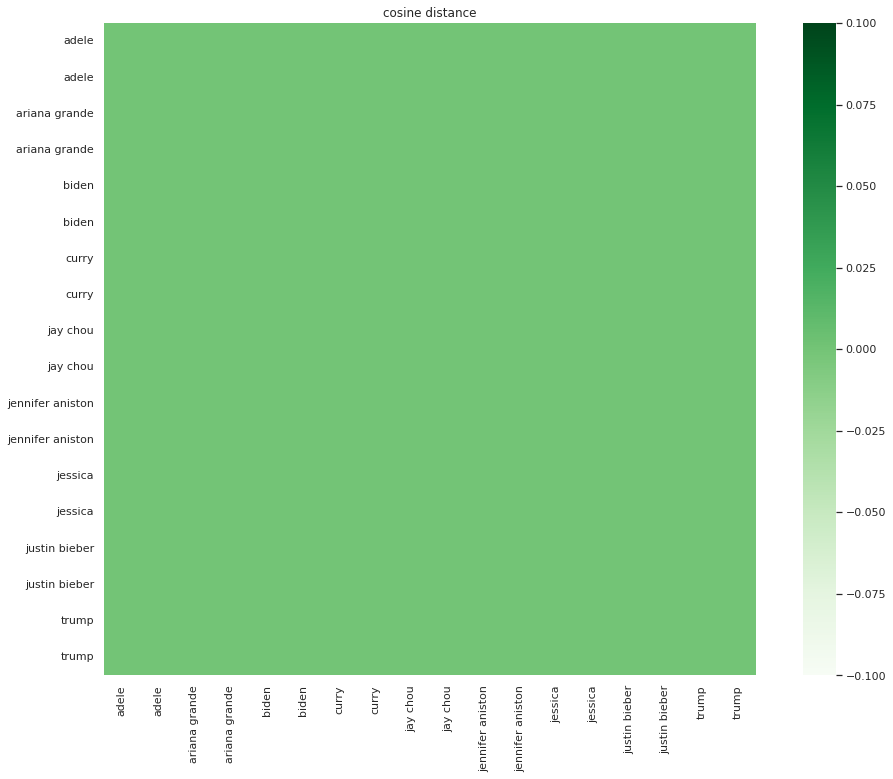

In [18]:
# Note 88 first images are original and 4247 are augmented
# as long as to calculate (4335, 512) distance matrix is time consuming we get only distances of originals 
inds = range(18)

# Train embeddings 
dists = getDist(trainEmbeds[inds], metric='euclidean', index=trainLabels[inds], columns=trainLabels[inds])
heatmap(dists, 'euclidean distance')

dists = getDist(trainEmbeds[inds], metric='cosine', index=trainLabels[inds], columns=trainLabels[inds])
heatmap(dists, 'cosine distance')

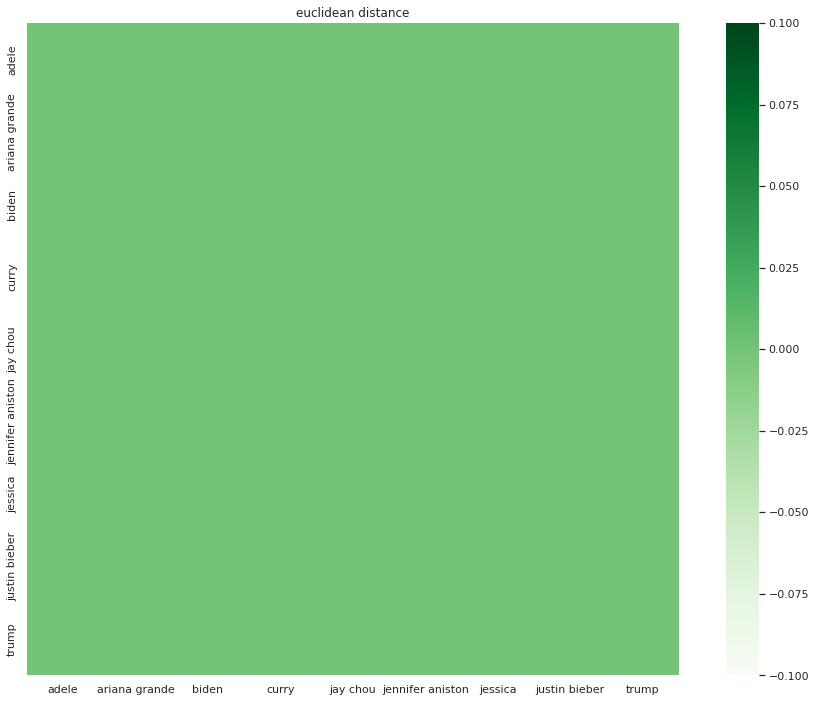

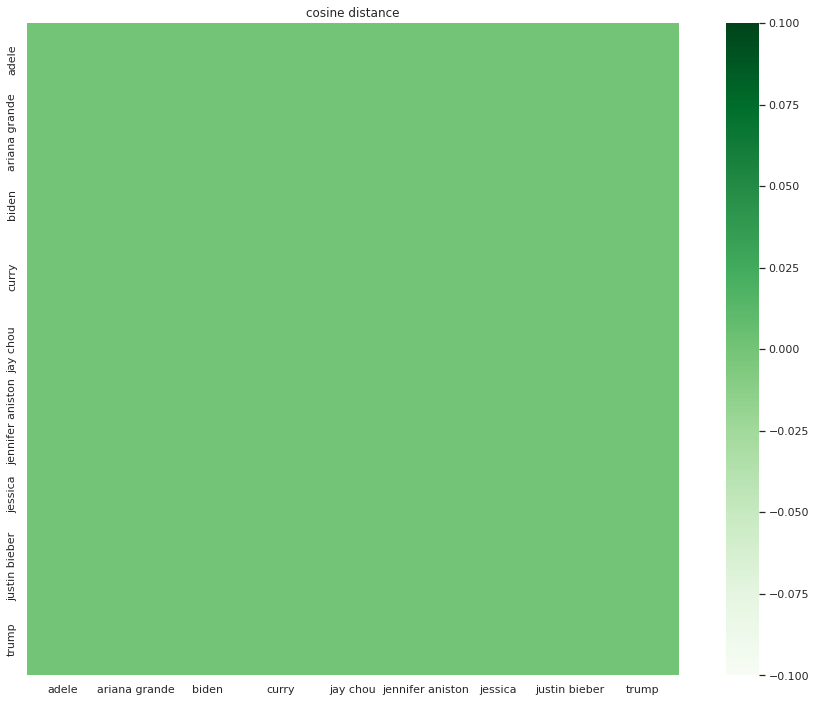

In [19]:
# Test embeddings 
dists = getDist(testEmbeds, metric='euclidean', index=testLabels, columns=testLabels)
heatmap(dists, 'euclidean distance')

dists = getDist(testEmbeds, metric='cosine', index=testLabels, columns=testLabels)
heatmap(dists, 'cosine distance')

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_pca.py:595: RuntimeWarning: divide by zero encountered in true_divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var.sum()
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


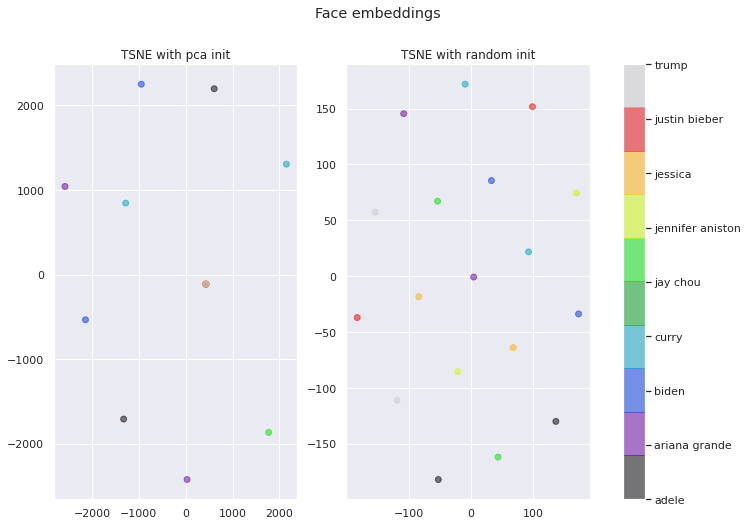

In [20]:
from sklearn.manifold import TSNE


inds = range(18)
X_tsne1 = TSNE(n_components=2, init='pca', random_state=33).fit_transform(trainEmbeds[inds])
X_tsne2 = TSNE(n_components=2, init='random', random_state=33).fit_transform(trainEmbeds[inds])
y = [CLASS_TO_IDX[label] for label in trainLabels[inds]]

fig, ax = plt.subplots(1, 2, figsize=(12, 8))

img = ax[0].scatter(X_tsne1[:, 0], X_tsne1[:, 1], c=y, alpha=0.5, cmap=plt.cm.get_cmap('nipy_spectral', 10))
ax[1].scatter(X_tsne2[:, 0], X_tsne2[:, 1], c=y, alpha=0.5, cmap=plt.cm.get_cmap('nipy_spectral', 10))

ax[0].set_title('TSNE with pca init')
ax[1].set_title('TSNE with random init')
plt.suptitle('Face embeddings')

cbar = plt.colorbar(img, ax=ax)
cbar.ax.set_yticklabels(np.unique(trainLabels[inds])) 
plt.show()

<class 'range'>


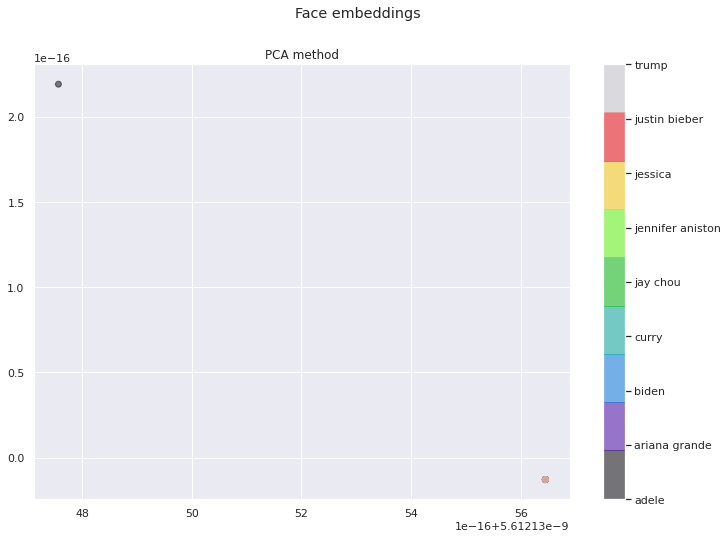

In [21]:
from sklearn.decomposition import PCA


inds = range(18)
print(type(inds))
X_pca1 = PCA(n_components=2, random_state=33).fit_transform(trainEmbeds[inds])
y = [CLASS_TO_IDX[label] for label in trainLabels[inds]]

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
img = ax.scatter(X_pca1[:, 0], X_pca1[:, 1], c=y, alpha=0.5, cmap=plt.cm.get_cmap('nipy_spectral', 9))

plt.title('PCA method')
plt.suptitle('Face embeddings')

cbar = plt.colorbar(img, ax=ax)
cbar.ax.set_yticklabels(np.unique(trainLabels[inds])) 
plt.show()

In [22]:
# data preparation 
X = np.copy(trainEmbeds)
y = np.array([CLASS_TO_IDX[label] for label in trainLabels])

print(f'X train embeds size: {X.shape}')
print(f'Tagret train size: {y.shape}')

X train embeds size: (918, 9)
Tagret train size: (918,)


In [23]:
%%time 

from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import warnings

warnings.filterwarnings('ignore', 'Solver terminated early.*')

param_grid = {'C': [1, 10, 100, 1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1, 'auto'],
              'kernel': ['rbf', 'sigmoid', 'poly']}
model_params = {'class_weight': 'balanced', 'max_iter': 10, 'probability': True, 'random_state': 3}
model_svc = SVC(**model_params)
clf = GridSearchCV(model_svc, param_grid)
clf.fit(X, y)

print('Best estimator: ', clf.best_estimator_)
print('Best params: ', clf.best_params_)

Best estimator:  SVC(C=1, class_weight='balanced', gamma=0.0001, max_iter=10, probability=True,
    random_state=3)
Best params:  {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
CPU times: user 28.3 s, sys: 31.2 ms, total: 28.3 s
Wall time: 28.2 s


In [24]:
import joblib

SVM_PATH = os.path.join(DATA_PATH, 'svm.sav')
joblib.dump(clf, SVM_PATH)
clf = joblib.load(SVM_PATH)

In [25]:
# test data preparation 
X_test, y_test = np.copy(testEmbeds), np.array([CLASS_TO_IDX[label] for label in testLabels])
print(f'X train embeds size: {X_test.shape}')
print(f'Tagret train size: {y_test.shape}')

X train embeds size: (9, 9)
Tagret train size: (9,)


In [26]:
from sklearn.metrics import accuracy_score

inds = range(18)
train_acc = accuracy_score(clf.predict(X[inds]), y[inds])
print(f'Accuracy score on train data: {train_acc:.3f}')

test_acc = accuracy_score(clf.predict(X_test), y_test)
print(f'Accuracy score on test data: {test_acc}')

Accuracy score on train data: 0.111
Accuracy score on test data: 0.1111111111111111
